In [18]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np







In [21]:

train_dir = 'Desktop/Semester 6/Optimization Techniques/Dataset/train'
val_dir = 'Desktop/Semester 6/Optimization Techniques/Dataset/validation'
test_dir = 'Desktop/Semester 6/Optimization Techniques/Dataset/test'



In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)




Found 2196 images belonging to 2 classes.
Found 2196 images belonging to 2 classes.
Found 2196 images belonging to 2 classes.


In [23]:
def build_model(learning_rate, dropout_rate):
    model = tf.keras.Sequential([
        layers.Input(shape=(150, 150, 3)),

        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

       
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

       
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),  
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model




In [24]:
def objective_function(params):
    learning_rate, dropout_rate = params
    model = build_model(learning_rate, dropout_rate)

    early_stop = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=5,
        callbacks=[early_stop],
        verbose=0
    )
    
    val_acc = history.history['val_accuracy'][-1]
    return -val_acc  




In [25]:
def pso_wrapper(x):
    return np.array([objective_function(p) for p in x])


In [26]:

bounds = ([1e-5, 0.1], [1e-2, 0.5])  
optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=2,
                                    options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
                                    bounds=bounds)

best_cost, best_pos = optimizer.optimize(pso_wrapper, iters=5)
print(f"Learning rate: {best_pos[0]}, Dropout rate: {best_pos[1]}")

2025-05-07 21:56:08,513 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=-0.961
2025-05-07 22:49:24,704 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9612932801246643, best pos: [0.00092713 0.38891934]


Learning rate: 0.0009271266135498835, Dropout rate: 0.3889193383528591


In [27]:

final_model = build_model(best_pos[0], best_pos[1])


history = final_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/15
69/69 [==============================] - 27s 378ms/step - loss: 0.4397 - accuracy: 0.7864 - val_loss: 0.2719 - val_accuracy: 0.8930
Epoch 2/15
69/69 [==============================] - 27s 388ms/step - loss: 0.2926 - accuracy: 0.8543 - val_loss: 0.2531 - val_accuracy: 0.8625
Epoch 3/15
69/69 [==============================] - 28s 402ms/step - loss: 0.2734 - accuracy: 0.8739 - val_loss: 0.2196 - val_accuracy: 0.8825
Epoch 4/15
69/69 [==============================] - 28s 401ms/step - loss: 0.2296 - accuracy: 0.8998 - val_loss: 0.1603 - val_accuracy: 0.9285
Epoch 5/15
69/69 [==============================] - 28s 399ms/step - loss: 0.2110 - accuracy: 0.9066 - val_loss: 0.1395 - val_accuracy: 0.9467
Epoch 6/15
69/69 [==============================] - 28s 400ms/step - loss: 0.2264 - accuracy: 0.8966 - val_loss: 0.1432 - val_accuracy: 0.9472
Epoch 7/15
69/69 [==============================] - 28s 413ms/step - loss: 0.1757 - accuracy: 0.9262 - val_loss: 0.1228 - val_accuracy: 0.9590

In [28]:
loss, accuracy = final_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



69/69 [==============================] - 6s 84ms/step - loss: 0.0313 - accuracy: 0.9954
Test Accuracy: 99.54%


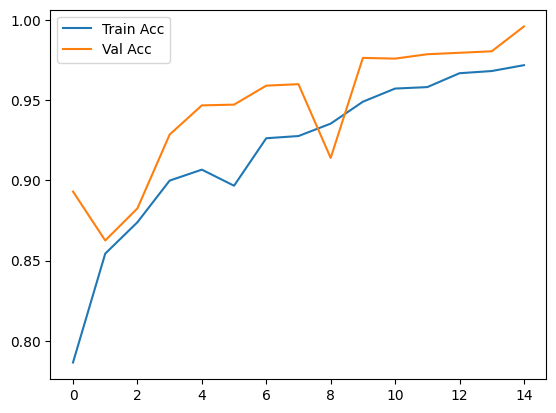

In [31]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


69/69 [==============================] - 5s 67ms/step


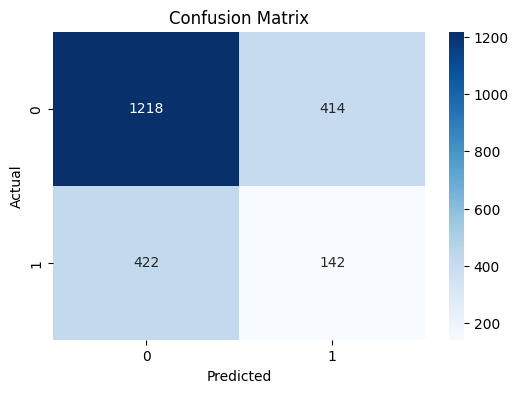

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1632
           1       0.26      0.25      0.25       564

    accuracy                           0.62      2196
   macro avg       0.50      0.50      0.50      2196
weighted avg       0.62      0.62      0.62      2196



In [38]:

y_pred = final_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")


y_true = test_generator.classes


cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print(classification_report(y_true, y_pred_classes))


In [39]:
final_model.save('road_safety_model.h5')
